# Train, tune, and deploy a custom ML model using <font color='red'>AIA(AI-Advisor) Multivariate Anomaly Detection(U-MAD) </font> Algorithm from AWS Marketplace 

⚠ **Change the link for the `AIA-MAD-ALGO` the current link is our gitlab link**

<font color='red'> This algorithm detects anomaly points or patterns for continuous multivariate time series data using unsupervised Deep Learning Anomaly Detection approach. </font>

This sample notebook shows you how to train a custom ML model using <font color='red'> For Seller to update: [AIA-MAD-ALGO](http://mod.lge.com/hub/ai_contents_marketplace/aia-ml-marketplace)</font> from AWS Marketplace.

> **Note**: This is a reference notebook and it cannot run unless you make changes suggested in the notebook.

## Pre-requisites
1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to <font color='red'> For Seller to update: [AIA-MAD-ALGO](http://mod.lge.com/hub/ai_contents_marketplace/aia-ml-marketplace)</font>. 

## Contents
1. [Subscribe to the algorithm](#1.-Subscribe-to-the-algorithm)
2. [Prepare dataset](#2.-Prepare-dataset)
	1. [Dataset format expected by the algorithm](#A.-Dataset-format-expected-by-the-algorithm)
	2. [Configure and visualize train and test dataset](#B.-Configure-and-visualize-train-and-test-dataset)
	3. [Upload datasets to Amazon S3](#C.-Upload-datasets-to-Amazon-S3)
3. [Train a machine learning model](#3:-Train-a-machine-learning-model)
	1. [Set up environment](#3.1-Set-up-environment)
	2. [Train a model](#3.2-Train-a-model)
4. [Deploy model and verify results](#4:-Deploy-model-and-verify-results)
    1. [Deploy trained model](#A.-Deploy-trained-model)
    2. [Create input payload](#B.-Create-input-payload)
    3. [Perform real-time inference](#C.-Perform-real-time-inference)
    4. [Visualize output](#D.-Visualize-output)
    5. [Delete the endpoint](#E.-Delete-the-endpoint)
5. [Perform Batch inference](#5.-Perform-Batch-inference)
6. [Clean-up](#6.-Clean-up)
	1. [Delete the model](#A.-Delete-the-model)
	2. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))


## Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

## 1. Subscribe to the algorithm

To subscribe to the algorithm:
1. Open the algorithm listing page [AIA-MAD-ALGO](http://mod.lge.com/hub/ai_contents_marketplace/aia-ml-marketplace)
1. On the AWS Marketplace listing,  click on **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn**. This is the algorithm ARN that you need to specify while training a custom ML model. Copy the ARN corresponding to your region and specify the same in the following cell.

![product_arn_image](images/product_arn_image.png)

In [1]:
from getpass import getpass 

# SHAPE
# algo_arn = "<Customer to specify algorithm ARN corresponding to their AWS region follow the instruction above>"
########################################CHANGE####################################################
# SAMPLE
algo_arn='arn:aws:sagemaker:us-east-2:438613450817:algorithm/aiadvisor-mad-v1-1-4'
##################################################################################################

# get your seesion information
#####################################################
aws_region = "us-east-2"  ##
aws_access_key = getpass(prompt="Access key: ")
aws_secret_key = getpass(prompt="Secret key: ")
######################aws_access_key#########################

Access key:  ········
Secret key:  ········


## 2. Prepare dataset

In [2]:
import base64
import json
import uuid
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker import ModelPackage
from urllib.parse import urlparse
import boto3
from IPython.display import Image
from PIL import Image as ImageEdit
import urllib.request
import numpy as np
import pandas as pd

### A. Dataset format expected by the algorithm

This solution follows these **2 steps**:  `Training` and `Testing` the algorithm.

**Train**
- The algorithm trains on user provided dataset.
- Dataset must be in `txt/csv` shape, under `./data/train/` folder, with 'utf-8' encoding.

**Test**
- After the Machine Learning model is trained, it can be used to make prediction using test dataset.
- The algorithm also tests on user provided dataset.
- Dataset must be in `txt/csv` shape, under `./data/inference/` folder, with 'utf-8' encoding.

### B. Configure and visualize train and test dataset
The `train` and `test` dataset should look like this as below:

In [3]:
import pandas as pd # import padas to show how data looks like

In [4]:
# SHAPE
# training_dataset = "data/train/<FileName.ext>"

########################################CHANGE####################################################
# SAMPLE
training_dataset = "data/train/train.csv"
##################################################################################################

In [5]:
# show sample of training dataset
df_train = pd.read_csv(training_dataset)
df_train.head()

,Time,Bearing1,Bearing2,Bearing3,Bearing4
0,2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
1,2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2,2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118
3,2004-02-12 11:22:39,0.061665,0.073279,0.084879,0.044172
4,2004-02-12 11:32:39,0.061944,0.074593,0.082626,0.044659


In [6]:
# SHAPE
# test_dataset = "data/test/<FileName.ext>"

########################################CHANGE####################################################
# SAMPLE
test_dataset = "data/inference/test.csv"
##################################################################################################

In [7]:
# show sample of test dataset
df_test = pd.read_csv(test_dataset)
df_test.head()

,Time,Bearing1,Bearing2,Bearing3,Bearing4
0,2004-02-15 12:52:39,0.061652,0.074332,0.075826,0.043743
1,2004-02-15 13:02:39,0.061667,0.074043,0.076449,0.044803
2,2004-02-15 13:12:39,0.059932,0.074051,0.075502,0.044021
3,2004-02-15 13:22:39,0.059952,0.073974,0.076825,0.043490
4,2004-02-15 13:32:39,0.060587,0.074444,0.077079,0.044251


### C. Upload datasets to Amazon S3

<font color='red'>Do not change bucket parameter value. Do not hardcode your S3 bucket name.</font>

In [8]:
import boto3
import sagemaker



boto_session = boto3.Session(region_name=aws_region, aws_access_key_id=aws_access_key, aws_secret_access_key=aws_secret_key)
sagemaker_session = sagemaker.Session(boto_session=boto_session) # get session info


bucket = sagemaker_session.default_bucket()
bucket

'sagemaker-us-east-2-438613450817'

In [9]:
# upload training data to s3 bucket
algo_prefix = "multivariate-anomaly-detection"
training_data = sagemaker_session.upload_data(training_dataset, bucket=bucket, key_prefix=algo_prefix + "/traing-input-data")
print("Training input uploaded to : " + training_data)

Training input uploaded to : s3://sagemaker-us-east-2-438613450817/multivariate-anomaly-detection/traing-input-data/train.csv


In [10]:
# upload test data to s3 bucket
test_data = sagemaker_session.upload_data(test_dataset, bucket=bucket, key_prefix=algo_prefix+"/inference-input-data")
print("Inference input uploaded to : " + test_data)

Inference input uploaded to : s3://sagemaker-us-east-2-438613450817/multivariate-anomaly-detection/inference-input-data/test.csv


## 3: Train a machine learning model

Now that dataset is available in an accessible Amazon S3 bucket, we are ready to train a machine learning model. 

### 3.1 Set up environment

In [11]:
## If you are running on a local server, enter the role name specified in IAM role.

sts = boto3.client('sts', region_name=aws_region, aws_access_key_id=aws_access_key, aws_secret_access_key=aws_secret_key)
caller_identity = sts.get_caller_identity()
account_id = caller_identity['Account']
role_name = input("Role name: ")
role = f'arn:aws:iam::{account_id}:role/{role_name}'


### If you are running in sagemaker jupyter notebook then uncomment the below. (The above is commented out.) 

#from sagemaker import get_execution_role
#role = get_execution_role(sagemaker_session=sagemaker_session)

print (f"Result: {role}")

Role name:  sagemaker-operation


Result: arn:aws:iam::438613450817:role/sagemaker-operation


<font color='red'>For Seller to update: update algorithm sepcific unique prefix in following cell. </font>

In [12]:
# SHAPE
# output_location = "s3://{}/<For seller to Update:Update a unique prefix>/{}".format(bucket, "output")

########################################CHANGE####################################################
# SAMPLE
output_location = "s3://{}/ai-advisor-umad/{}".format(bucket, "output")
##################################################################################################

### 3.2 Train a model

You can also find more information about dataset format in **Hyperparameters** section of [AI-Advisor UMAD](https://github.com/AI-Advisor-ML-Marketplace/multivariate-anomaly-detection).

In [13]:
# SHAPE
# hyperparameters = {}

########################################CHANGE####################################################
# Define hyperparameters
hyperparameters = {
            'x_columns': 'Bearing1,Bearing2,Bearing3,Bearing4',
            'time_column': 'Time'
}
##################################################################################################

<font color='red'>For Seller to update: Update appropriate values in estimator definition and ensure that fit call works as expected.</font>

For information on creating an `Estimator` object, see [documentation](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html)

In [14]:
training_data

's3://sagemaker-us-east-2-438613450817/multivariate-anomaly-detection/traing-input-data/train.csv'

In [16]:
########################################CHANGE####################################################
# Create an estimator object for running a training job
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    base_job_name="ai-advisor-umad",
    role=role,
    instance_count=1,
    instance_type='ml.c5.xlarge',
    input_mode="File",
    output_path=output_location,
    sagemaker_session=sagemaker_session,
    hyperparameters=hyperparameters,
)
##################################################################################################

# Run the training job.
estimator.fit({'training': training_data})

INFO:sagemaker:Creating training-job with name: ai-advisor-umad-2023-03-31-13-59-54-972


2023-03-31 13:59:55 Starting - Starting the training job...
2023-03-31 14:00:10 Starting - Preparing the instances for training...
2023-03-31 14:01:00 Downloading - Downloading input data...
2023-03-31 14:01:20 Training - Downloading the training image.........
2023-03-31 14:03:01 Training - Training image download completed. Training in progress.json_path:  /opt/ml/input/config/hyperparameters.json
yaml_path:  /opt/program/framework/configure/mad.train.workflow.yaml
current mode :  train
##############Train Hyperparameters overload complete##############
json_path:  /opt/ml/input/config/hyperparameters.json
yaml_path:  /opt/program/framework/configure/mad.inference.workflow.yaml
current mode :  inference
##############Inference Hyperparameters overload complete##############
Train, Inference hyperparams overriden!
aip yaml file is replaced with aip_train yaml file!
Start Train Pipeline!
2023-03-31 14:03:06.999008: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could n

See this [blog-post](https://aws.amazon.com/blogs/machine-learning/easily-monitor-and-visualize-metrics-while-training-models-on-amazon-sagemaker/) for more information how to visualize metrics during the process. You can also open the training job from [Amazon SageMaker console](https://console.aws.amazon.com/sagemaker/home?#/jobs/) and monitor the metrics/logs in **Monitor** section.

## 4: Deploy model and verify results

Now you can deploy the model for performing real-time inference.

In [17]:
########################################CHANGE####################################################
model_name = "ai-advisor-upad"
content_type='text/csv'

# set instance type
instance_type = 'ml.c5.2xlarge'
##################################################################################################

### A. Deploy trained model

In [18]:
from sagemaker.predictor import csv_serializer

# deploy model
predictor = estimator.deploy(
    initial_instance_count=1, 
    instance_type= instance_type, 
    serializer=csv_serializer)

INFO:sagemaker:Creating model package with name: ai-advisor-umad-2023-03-31-14-06-43-896


.........


INFO:sagemaker:Creating model with name: ai-advisor-umad-2023-03-31-14-06-43-896
INFO:sagemaker:Creating endpoint-config with name ai-advisor-umad-2023-03-31-14-06-43-896
INFO:sagemaker:Creating endpoint with name ai-advisor-umad-2023-03-31-14-06-43-896


------!

Once endpoint is created, you can perform real-time inference.

### B. Create input payload

In [19]:
file_name = "data/inference/test.csv"

<Add code snippet that shows the payload contents>

### C. Perform real-time inference

In [20]:
import pandas as pd
import io

runtime = boto3.client('sagemaker-runtime', region_name=aws_region, aws_access_key_id=aws_access_key, aws_secret_access_key=aws_secret_key)


In [23]:
response = runtime.invoke_endpoint(
    EndpointName=predictor.endpoint_name,
    ContentType=content_type,
    #Body=file_name.encode('utf-8'),
    Body=open(file_name, 'rb').read(),
    Accept=content_type
)

content = response['Body'].read()
binary_stream = io.BytesIO(content)

In [24]:
import tarfile
from PIL import Image


with tarfile.open(fileobj=binary_stream, mode='r') as tar:
    csv_contents = list()
    image_contents = list()
    for member in tar.getmembers():
        if member.name.endswith('.csv'):
            csv_contents.append(tar.extractfile(member).read())
        elif member.name.endswith('.png'):
            image_contents.append(tar.extractfile(member).read())

if len(csv_contents) != 0 :
    for csv_raw in csv_contents:
        result_df = pd.read_csv(io.StringIO(csv_raw.decode('utf-8')))
        display(result_df)
        
# if len(image_contents) != 0 : 
#     for img_raw in image_contents:
#         img = Image.open(io.BytesIO(img_raw))

,Time,loss,timestamp,thr,Anomaly
0,2004-02-15 14:12:39,0.772081,2004-02-15 14:12:39,4.175663,False
1,2004-02-15 14:22:39,0.824121,2004-02-15 14:22:39,4.175663,False
2,2004-02-15 14:32:39,0.785536,2004-02-15 14:32:39,4.175663,False
3,2004-02-15 14:42:39,0.726201,2004-02-15 14:42:39,4.175663,False
4,2004-02-15 14:52:39,0.924871,2004-02-15 14:52:39,4.175663,False
...,...,...,...,...,...
525,2004-02-19 05:42:39,38203.101642,2004-02-19 05:42:39,4.175663,True
526,2004-02-19 05:52:39,38986.083526,2004-02-19 05:52:39,4.175663,True
527,2004-02-19 06:02:39,40511.199825,2004-02-19 06:02:39,4.175663,True
528,2004-02-19 06:12:39,38060.231694,2004-02-19 06:12:39,4.175663,True


### D. Visualize output

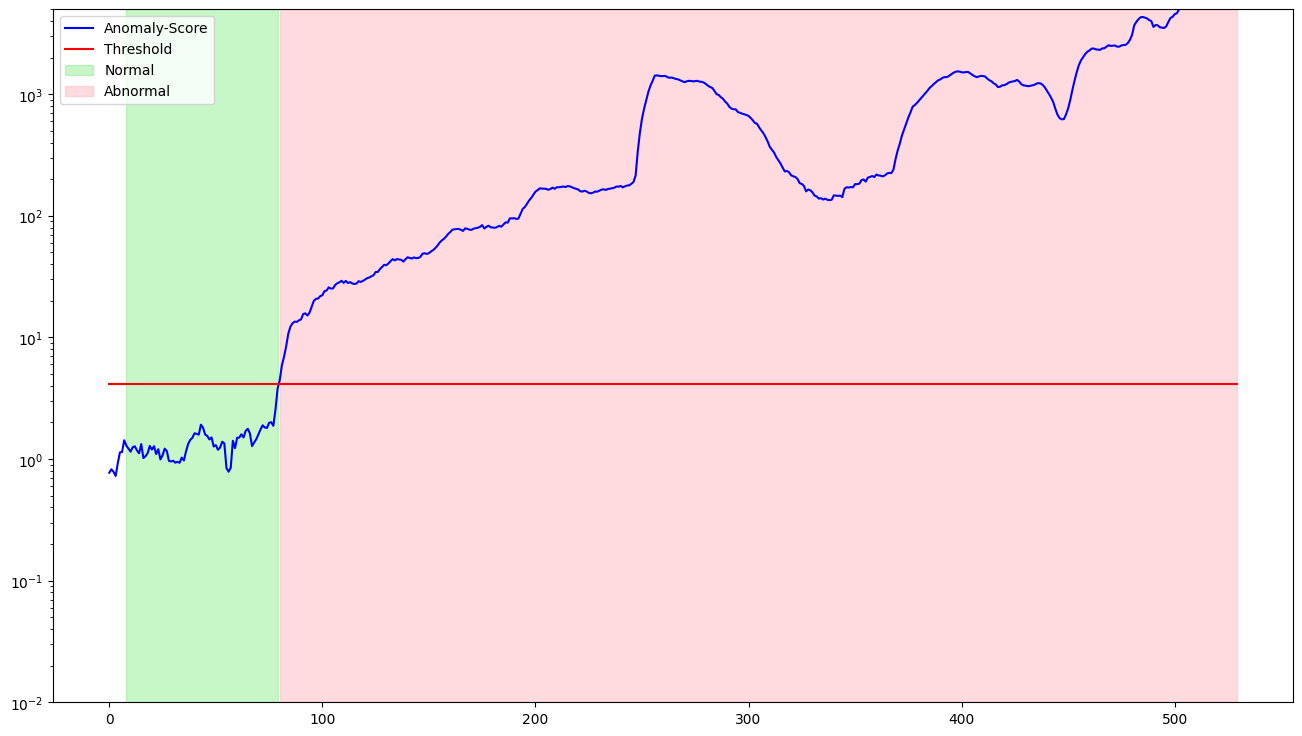

In [26]:
## Accurate plot with lookback value
import matplotlib.pyplot as plt

#################################################################
y_upper = 5e3
y_lower = 1e-2

LOOKBACK_SIZE = 9
lookback = LOOKBACK_SIZE - 1
#################################################################

result_df.rename(columns = {'loss':'Anomaly-Score','thr':'Threshold'}, inplace=True)
labels = result_df['Anomaly']

ax = result_df.plot(logy=True,  figsize=(16,9), ylim=[y_lower,y_upper], color=['blue','red'])
ax.fill_between(result_df.index[lookback:],
                y_upper, y_lower, 
                where=labels[lookback:] == False,
                color='lightgreen',
                alpha=0.5,
                label='Normal')

ax.fill_between(result_df.index[lookback:],
                y_upper, y_lower,
                where=labels[lookback:] == True,
                color='lightpink',
                alpha=0.5,
                label='Abnormal')

# # ax.axvline(critical_date, color="green", linestyle="dashed")
# plt.text("2004-02-14 00:00:00", 1e3, s='Train:Normal', fontsize=15)
# plt.text("2004-02-15 14:00:00", 1e3, s='Test:Normal/Abnormal', fontsize=15)

plt.legend(loc="upper left")
plt.show()

### E. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. you can terminate the same to avoid being charged.

In [27]:
predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: ai-advisor-umad-2023-03-31-14-06-43-896
INFO:sagemaker:Deleting endpoint with name: ai-advisor-umad-2023-03-31-14-06-43-896


## 5. Perform Batch inference

In this section, you will perform batch inference using multiple input payloads together.

In [28]:
########################################CHANGE####################################################
# upload the batch-transform job input files to S3
transform_dataset = "data/inference/test.csv"
##################################################################################################

transform_input = sagemaker_session.upload_data(transform_dataset, key_prefix=model_name)
print("Transform input uploaded to : " + transform_input)

Transform input uploaded to : s3://sagemaker-us-east-2-438613450817/ai-advisor-upad/test.csv


In [29]:
# Run the batch-transform job
transformer = estimator.transformer(instance_count=1, instance_type=instance_type)
transformer.transform(transform_input, content_type=content_type)
transformer.wait()

INFO:sagemaker:Creating model package with name: aiadvisor-mad-v1-1-4-2023-03-31-14-22-14-538


.........


INFO:sagemaker:Creating model with name: aiadvisor-mad-v1-1-4-2023-03-31-14-22-1-2023-03-31-14-23-01-909
INFO:sagemaker:Creating transform job with name: ai-advisor-umad-2023-03-31-14-23-03-062


.............................Starting the inference server with 8 workers.
[2023-03-31 14:28:28 +0000] [10] [INFO] Starting gunicorn 20.1.0
[2023-03-31 14:28:28 +0000] [10] [INFO] Listening at: unix:/tmp/gunicorn.sock (10)
[2023-03-31 14:28:28 +0000] [10] [INFO] Using worker: gevent
[2023-03-31 14:28:28 +0000] [13] [INFO] Booting worker with pid: 13
[2023-03-31 14:28:28 +0000] [14] [INFO] Booting worker with pid: 14
[2023-03-31 14:28:28 +0000] [15] [INFO] Booting worker with pid: 15
[2023-03-31 14:28:28 +0000] [23] [INFO] Booting worker with pid: 23
[2023-03-31 14:28:28 +0000] [24] [INFO] Booting worker with pid: 24
[2023-03-31 14:28:28 +0000] [39] [INFO] Booting worker with pid: 39
[2023-03-31 14:28:28 +0000] [40] [INFO] Booting worker with pid: 40
[2023-03-31 14:28:29 +0000] [41] [INFO] Booting worker with pid: 41
model_name existing:  ['scaler.pickle', '3_lstm_epoch300.h5', 'bestmodel_9_lstm_epoch300.h5', '2_lstm_epoch300.h5', 'output.pickle', 'train_output', 'inference_config', '7_

In [30]:
# output is available on following path
transformer.output_path

's3://sagemaker-us-east-2-438613450817/ai-advisor-umad-2023-03-31-14-23-03-062'

## 7. Clean-up

### A. Delete the model

In [31]:
predictor.delete_model()

ClientError: An error occurred (ValidationException) when calling the DescribeEndpointConfig operation: Could not find endpoint configuration "arn:aws:sagemaker:us-east-2:438613450817:endpoint-config/ai-advisor-umad-2023-03-31-14-06-43-896".

### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the algorithm, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

